In [1]:
import numpy as np
from scipy.optimize import curve_fit

import uproot

import seaborn as sns
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt

import zfit
import zfit.z.numpy  
from zfit import z 

/home/sahil/anaconda3/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
signame = ['../Signal_0.4GeV(1).root',
           '../Signal_0.6GeV(1).root',
           '../Signal_0.8GeV(1).root',
           '../Signal_1GeV(1).root',
           '../Signal_2GeV(1).root',
           '../Signal_4GeV(1).root',
           '../Signal_6GeV(1).root',
           '../Signal_8GeV(1).root',
           '../Signal_9GeV(1).root'
          ]

sigmag = ['0.4 GeV', '0.6 GeV', '0.8 GeV', '1.0 GeV', '2.0 GeV', '4.0 GeV', '6.0 GeV', '8.0 GeV', '9.0 GeV']

datsig = [uproot.open(x) for x in signame]

filesig = [x['mumu'].arrays(library='np') for x in datsig]

In [3]:
def csfunc(eps, m):
    
    alpha = 1/137
    
    Ecom = 10.58
    thetamax = 12*np.pi/180
    thetamin = 155*np.pi/180
    
    Theta = np.log(((1+np.cos(thetamax))*(1-np.cos(thetamin)))/((1-np.cos(thetamax))*(1+np.cos(thetamin))))
    
    a = (2 * np.pi * alpha**2)/(Ecom**2) * eps**2
    
    b = 1 - m**2/Ecom**2
    
    c = 1 + (2 * m**2/Ecom**2)/b**2
    
    sigmagev = a * b * (c * Theta - np.cos(thetamax) + np.cos(thetamin))
                     
    sigmaSI = sigmagev * (0.197*1e-15)**2
    
    sigmafb = sigmaSI * (10**43)
    
    return sigmafb

In [4]:
epsilon = np.linspace(5e-4, 3e-3, 25)
m = [0.4, 0.6, 0.8, 1, 2, 4, 6, 8, 9]

lumi = 514

sgm = np.zeros([len(epsilon),len(m)])

nsig = np.zeros([len(epsilon),len(m)])

for j in range(len(epsilon)):
    for i in range(len(m)):
        sgm[j][i] = csfunc(epsilon[j],m[i])
        nsig[j][i] = len(filesig[i]['__experiment__'])/10000 * lumi * sgm[j][i]

In [5]:
sig = [[[] for i in range(len(m))] for j in range(len(epsilon))]
bkg = [[[] for i in range(len(m))] for j in range(len(epsilon))]

dat = [[[] for i in range(len(m))] for j in range(len(epsilon))]

for i in range(len(epsilon)):
    for j in range(len(m)):
        
        range_ = (0.95*m[j], 1.05*m[j])
        
        bins_ = 30
        
        for k in range(int(nsig[i][j])):
            choice = np.random.randint(0,len(filesig[j]['__experiment__']))
            if filesig[j]['ap_InvM'][choice]>range_[0] and filesig[j]['ap_InvM'][choice]<range_[1]:
                sig[i][j].append(filesig[j]['ap_InvM'][choice])

        file_path = 'output'+ str(m[j]) + '_514.txt'

        bkg[i][j] = np.loadtxt(file_path, delimiter=',')
        
        dat[i][j] = np.concatenate((bkg[i][j],sig[i][j]))

In [6]:
#FUNCTION TO FIT BACKGROUND
def func(x, a):
    return np.exp(a*x)

#BACKGROUND FIT PARAMETER
bkglam = [[ None for i in range(len(m))] for j in range(len(epsilon))]

#FIT PARAMETERS
lam = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namelam = 'lam' + '_' + str(i) + '_' + str(j)
        lam[i][j] = zfit.Parameter(namelam, 1)

exp_yield = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        nameexpyield = 'exp_yield' + '_'  + str(i) + '_'  + str(j)
        exp_yield[i][j] = zfit.Parameter(nameexpyield, 10000, step_size = 1)


sigma = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        sd = np.std(sig[i][j])
        namesigma = 'sigma' + '_'  + str(i) + '_'  + str(j)
        sigma[i][j] = zfit.Parameter(namesigma, sd)

alphal = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namealphal = 'alpha_l' + '_'  + str(i) + '_'  + str(j)
        alphal[i][j] = zfit.Parameter(namealphal, 1)
        
nl = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namenl = 'n_l' + '_' + str(i) + '_' + str(j)
        nl[i][j] = zfit.Parameter(namenl, 1)
        
alphar = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namealphar = 'alpha_r' + '_' + str(i) + '_' + str(j)
        alphar[i][j] = zfit.Parameter(namealphar, 1)
        
nr = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namenr = 'n_r' + '_' + str(i) + '_' + str(j)
        nr[i][j] = zfit.Parameter(namenr, 1)

dcb_yield = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namedcbyield = 'dcb_yield' + '_' + str(i) + '_' + str(j)
        dcb_yield[i][j] = zfit.Parameter(namedcbyield, 200, step_size = 1)

mu = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namemu = 'mu' + '_' + str(i) + '_' + str(j)
        mu[i][j] = zfit.Parameter(namemu, m[j])
        
#CALCULATION PARAMETERS
        
dcb = [[ None for i in range(len(m))] for j in range(len(epsilon))]
nll = [[ None for i in range(len(m))] for j in range(len(epsilon))]

exp = [[ None for i in range(len(m))] for j in range(len(epsilon))]
nll1 = [[ None for i in range(len(m))] for j in range(len(epsilon))]

totalpdf = [[ None for i in range(len(m))] for j in range(len(epsilon))]
nllfinal = [[ None for i in range(len(m))] for j in range(len(epsilon))]
dcb_yield_poi = [[ None for i in range(len(m))] for j in range(len(epsilon))]
discovery = [[ None for i in range(len(m))] for j in range(len(epsilon))]

minimizer = [[ None for i in range(len(m))] for j in range(len(epsilon))]
minimizer1 = [[ None for i in range(len(m))] for j in range(len(epsilon))]
minimizer2 = [[ None for i in range(len(m))] for j in range(len(epsilon))]

minimum = [[ None for i in range(len(m))] for j in range(len(epsilon))]
minimum1 = [[ None for i in range(len(m))] for j in range(len(epsilon))]
check = [[ None for i in range(len(m))] for j in range(len(epsilon))]

calculator = [[ None for i in range(len(m))] for j in range(len(epsilon))]

#OUTPUT SIGNIFICANCE
final = [[ None for i in range(len(m))] for j in range(len(epsilon))]

In [7]:
for i in range(len(epsilon)):
    for j in range(len(m)):
        try:
            y = np.array(sig[i][j])

            range_ = (0.95*np.mean(y), 1.05*np.mean(y))

            obs = zfit.Space('x', limits=range_)
            data = zfit.data.Data.from_numpy(obs=obs, array=y)

            dcb[i][j] = zfit.pdf.DoubleCB(obs=obs, mu=mu[i][j], sigma=sigma[i][j], alphal = alphal[i][j], nl = nl[i][j], alphar = alphar[i][j], nr = nr[i][j])
            dcb[i][j].set_yield(dcb_yield[i][j])

            nll[i][j] = zfit.loss.ExtendedUnbinnedNLL(model=dcb[i][j], data=data) 

            minimizer[i][j] = zfit.minimize.Minuit()
            minimum[i][j] = minimizer[i][j].minimize(loss=nll[i][j])

            params = minimum[i][j].params

            ############################################

            y1 = np.array(bkg[i][j])

            obs = zfit.Space('x', limits=range_)
            data1 = zfit.data.Data.from_numpy(obs=obs, array=y1)

            exp[i][j] = zfit.pdf.Exponential(lam = lam[i][j], obs=obs)
            exp[i][j].set_yield(exp_yield[i][j])

            nll1[i][j] = zfit.loss.ExtendedUnbinnedNLL(model=exp[i][j], data=data1) 

            minimizer1[i][j] = zfit.minimize.Minuit()
            minimum1[i][j] = minimizer1[i][j].minimize(loss=nll1[i][j])

            params1 = minimum1[i][j].params

            ############################################
            
            totalpdf[i][j] = zfit.pdf.SumPDF([exp[i][j],dcb[i][j]])

            mu[i][j].floating = False
            sigma[i][j].floating = False
            alphal[i][j].floating = False
            nl[i][j].floating = False
            alphar[i][j].floating = False
            nr[i][j].floating = False
            lam[i][j].floating = False

            data2 = zfit.data.Data.from_numpy(obs=obs, array=np.array(dat[i][j]))

            nllfinal[i][j] = zfit.loss.ExtendedUnbinnedNLL(model = totalpdf[i][j], data = data2)

            minimizer2[i][j] = zfit.minimize.Minuit()
            check[i][j] = minimizer2[i][j].minimize(nllfinal[i][j])
            print(check[i][j])

            from hepstats.hypotests.calculators import AsymptoticCalculator
            from hepstats.hypotests.parameters import POI

            dcb_yield_poi[i][j] = POI(dcb_yield[i][j], 0)
            calculator[i][j] = AsymptoticCalculator(input = nllfinal[i][j], minimizer = minimizer2[i][j])
            
            from hepstats.hypotests import Discovery

            discovery[i][j] = Discovery(calculator = calculator[i][j], poinull = dcb_yield_poi[i][j])
        
        except Exception:
            continue

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.core.data.Data object at 0x7f5bd13ffca0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00032 │ 9997.95     │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_0_0              217419       False
dcb_yield_0_0             1071.17       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_4, Composed_autoparam_5]] data=[<zfit.core.data.Data object at 0x7f5bce178ee0>] constraints=[]> 
with
<Min

│ True    │ True        │ False            │ 5.3e-07 │ 10002.69    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_1_1              202195       False
dcb_yield_1_1             405.379       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_34, Composed_autoparam_35]] data=[<zfit.core.data.Data object at 0x7f5bcdfd55d0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.2e-06 │ 10002.09    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  -----

│ True    │ True        │ False            │ 0.00018 │ 9998.804    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_2_3              185752       False
dcb_yield_2_3             949.888       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_67, Composed_autoparam_68]] data=[<zfit.core.data.Data object at 0x7f5bb0776a40>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.9e-06 │ 10001.22    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  -----

│ True    │ True        │ False            │ 1.7e-05 │ 9999.236    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_3_5              371636       False
dcb_yield_3_5             1162.69       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_100, Composed_autoparam_101]] data=[<zfit.core.data.Data object at 0x7f5bb0662c20>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.3e-05 │ 9998.663    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ---

│ True    │ True        │ False            │ 3.1e-06 │ 9999.155    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_4_7         2.07832e+06       False
dcb_yield_4_7             1990.85       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_133, Composed_autoparam_134]] data=[<zfit.core.data.Data object at 0x7f5bcdf11540>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 4.7e-05 │ 9998.882    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ---

│ True    │ True        │ False            │ 0.00012 │ 10000.68    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_6_0              218730       False
dcb_yield_6_0             1744.73       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_166, Composed_autoparam_167]] data=[<zfit.core.data.Data object at 0x7f5ba14bc850>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm    │ min value   │
╞═════════╪═════════════╪══════════════════╪════════╪═════════════╡
│ True    │ True        │ False            │ 0.0003 │ 10002.86    │
╘═════════╧═════════════╧══════════════════╧════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  --------

│ True    │ True        │ False            │ 0.00041 │ 9998.645    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_8_3              185646       False
dcb_yield_8_3             1815.07       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_229, Composed_autoparam_230]] data=[<zfit.core.data.Data object at 0x7f5ba163e470>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.4e-05 │ 10001.2     │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ---

│ True    │ True        │ False            │ 4.1e-05 │ 9998.338    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  ------------------  ----------
exp_yield_10_6              762544       False
dcb_yield_10_6             4585.61       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_292, Composed_autoparam_293]] data=[<zfit.core.data.Data object at 0x7f5ba00bfa90>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.7e-05 │ 9998.723    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
-------------

│ True    │ True        │ False            │ 7.1e-08 │ 10001.63    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  ------------------  ----------
exp_yield_13_0              219049       False
dcb_yield_13_0             3249.12       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_355, Composed_autoparam_356]] data=[<zfit.core.data.Data object at 0x7f5b8bb6f190>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00039 │ 10002.86    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
-------------

│ True    │ True        │ False            │ 7e-07 │ 9997.774    │
╘═════════╧═════════════╧══════════════════╧═══════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  ------------------  ----------
exp_yield_15_3              185295       False
dcb_yield_15_3              3543.3       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_418, Composed_autoparam_419]] data=[<zfit.core.data.Data object at 0x7f5b8b419e70>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 3.7e-05 │ 10001.2     │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  -

│ True    │ True        │ False            │ 8.3e-07 │ 9985.833    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  ------------------  ----------
exp_yield_17_6              761896       False
dcb_yield_17_6             10753.9       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_481, Composed_autoparam_482]] data=[<zfit.core.data.Data object at 0x7f5b8aa7f850>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 8.5e-05 │ 9996.772    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
-------------

│ True    │ True        │ False            │ 1.9e-05 │ 9999.076    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  ------------------  ----------
exp_yield_20_0              218864       False
dcb_yield_20_0             6239.86       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_544, Composed_autoparam_545]] data=[<zfit.core.data.Data object at 0x7f5b8a82d8d0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.3e-08 │ 10002.77    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
-------------

│ True    │ True        │ False            │ 1.6e-08 │ 10002.44    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  ------------------  ----------
exp_yield_21_2              193046       False
dcb_yield_21_2             4974.67       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_577, Composed_autoparam_578]] data=[<zfit.core.data.Data object at 0x7f5b8906c8b0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 3.4e-06 │ 10000.05    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
-------------

│ True    │ True        │ False            │ 0.00022 │ 9999.005    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  ------------------  ----------
exp_yield_23_5              371188       False
dcb_yield_23_5             9487.32       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_640, Composed_autoparam_641]] data=[<zfit.core.data.Data object at 0x7f5b885b2890>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 6.5e-06 │ 9974.255    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
-------------

In [8]:
final = [[ None for i in range(len(m))] for j in range(len(epsilon))]

for i in range(len(epsilon)):
    for j in range(len(m)):
        try:
            k = discovery[i][j].result()[1]
            if discovery[i][j] != None:
                if k != float('inf'):
                    print(i,' ', j, ':')
                    final[i][j] = discovery[i][j].result()[1]
                else:
                    print(i,' ', j, ':')
                    final[i][j] = 10
            else:
                print(i,' ', j, ':')
                final[i][j] = 0
        except Exception:
            print(i,' ', j, ':')
            final[i][j] = 0
            continue

for i in range(len(epsilon)-1):
    for j in range(len(m)):
        if final[i+1][j] == 10 and final[i-1][j] == 10:
            final[i][j] = 10

Get fit best values!

p_value for the Null hypothesis = 2.9870795285047436e-05
Significance (in units of sigma) = 4.0138291717223105
0   0 :

p_value for the Null hypothesis = 2.9870795285047436e-05
Significance (in units of sigma) = 4.0138291717223105
Get fit best values!

p_value for the Null hypothesis = 0.23182760072369724
Significance (in units of sigma) = 0.7328413443788361
0   1 :

p_value for the Null hypothesis = 0.23182760072369724
Significance (in units of sigma) = 0.7328413443788361
Get fit best values!

p_value for the Null hypothesis = 2.8474686657453674e-06
Significance (in units of sigma) = 4.537409808273485
0   2 :

p_value for the Null hypothesis = 2.8474686657453674e-06
Significance (in units of sigma) = 4.537409808273485
Get fit best values!

p_value for the Null hypothesis = 0.0018847000051186447
Significance (in units of sigma) = 2.8968416176185268
0   3 :

p_value for the Null hypothesis = 0.0018847000051186447
Significance (in units of sigma) = 2.896841617618526

Significance (in units of sigma) = 6.844853228884518
7   3 :

p_value for the Null hypothesis = 3.827715922000152e-12
Significance (in units of sigma) = 6.844853228884518
Get fit best values!

p_value for the Null hypothesis = 1.5837331446277858e-12
Significance (in units of sigma) = 6.970086297513917
7   4 :

p_value for the Null hypothesis = 1.5837331446277858e-12
Significance (in units of sigma) = 6.970086297513917
Get fit best values!

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
7   5 :
Get fit best values!

p_value for the Null hypothesis = 1.1102230246251565e-16
Significance (in units of sigma) = 8.209536151601387
7   6 :

p_value for the Null hypothesis = 1.1102230246251565e-16
Significance (in units of sigma) = 8.209536151601387
Get fit best values!

p_value for the Null hypothesis = 3.4416913763379853e-15
Significance (in units of sigma) = 7.786604801354373
7   7 :

p_value for the Null hypothesis = 3.4416913763379853e-15
Significance (in units

Get fit best values!

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
22   1 :
Get fit best values!

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
22   2 :
Get fit best values!

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
22   3 :
Get fit best values!

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
22   4 :
Get fit best values!

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
22   5 :
Get fit best values!
22   6 :
Get fit best values!

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
22   7 :
Get fit best values!

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
22   8 :
Get fit best values!

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
23   0 :
Get fit best values!

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
23   1 

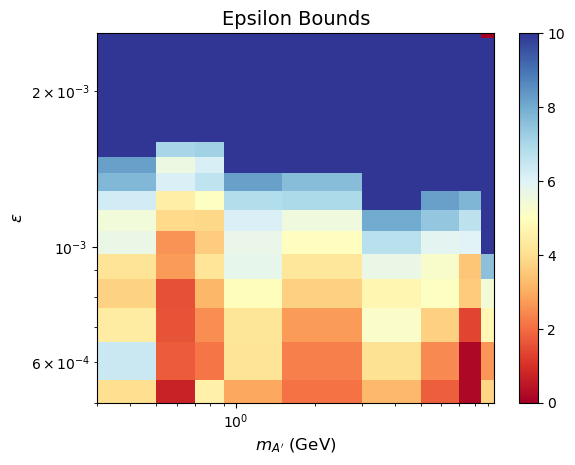

In [9]:
x, y = np.meshgrid(m, epsilon)

plt.tick_params(axis='x', which='minor')
plt.pcolormesh(x, y, final, cmap='RdYlBu')
plt.xlabel(r"$m_{A'}$ (GeV)",fontsize = 12)
plt.xscale('log')
plt.ylabel(r"$\epsilon$", fontsize = 12)
plt.yscale('log')
plt.ylim(epsilon[0],epsilon[-5])
plt.title("Epsilon Bounds", fontsize = 14)
plt.colorbar()
plt.show()

In [10]:
lims = []
nums = []
k = np.zeros(len(m))

for j in range(len(m)):
    for i in range(len(epsilon[:20])-2,0,-2):
        if final[i][j]<5:
            lims.append(epsilon[i+1])
            k[j] = 1
            nums.append(i+1)
            break
    if k[j]==0:
        lims.append(epsilon[0])
        nums.append(0)

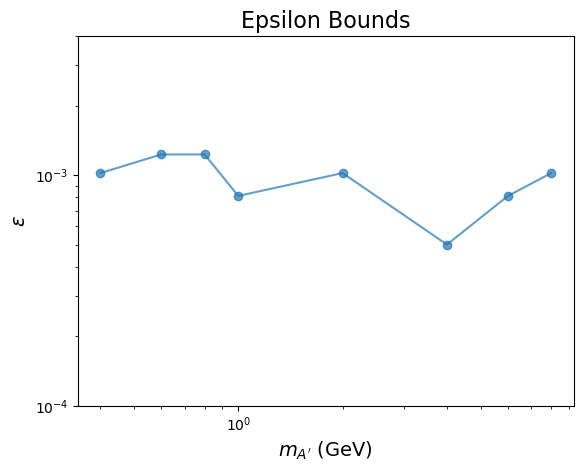

In [11]:
plt.plot(m[0:-1], lims[0:-1], 'o-',  alpha = 0.7)
plt.xlabel(r"$m_{A'}$ (GeV)", fontsize = 14)
plt.xscale('log')
plt.ylabel(r"$\epsilon$", fontsize = 14)
plt.yscale('log')
plt.ylim(1e-4,4e-3)
plt.title("Epsilon Bounds", fontsize = 16)
plt.show()

In [12]:
print(lims)

[0.0010208333333333332, 0.0012291666666666666, 0.0012291666666666666, 0.0008125000000000001, 0.0010208333333333332, 0.0005, 0.0008125000000000001, 0.0010208333333333332, 0.0008125000000000001]


Text(0.5, 0, "$m_{A'}$ (GeV)")

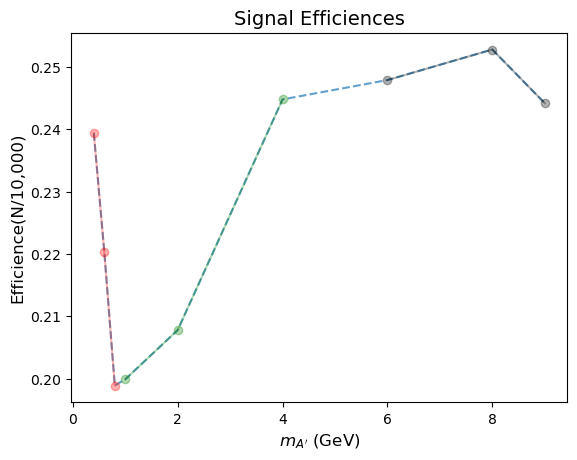

In [13]:
efficiencies = []

for i in range(len(m)):
    efficiencies.append(len(filesig[i]['__experiment__'])/10000)

plt.plot(m, efficiencies,  '--', alpha = 0.7)
plt.plot(m[0:3], efficiencies[0:3], 'o-', alpha = 0.3, color = 'red')
plt.plot(m[3:6], efficiencies[3:6], 'o-', alpha = 0.3, color = 'green')
plt.plot(m[6:], efficiencies[6:], 'o-', alpha = 0.3, color = 'black')

plt.title('Signal Efficiences', fontsize = 14)
plt.ylabel('Efficience(N/10,000)', fontsize = 12)
plt.xlabel(r"$m_{A'}$ (GeV)", fontsize = 12)

In [16]:
from hepstats.hypotests.parameters import POI, POIarray
from hepstats.hypotests import UpperLimit

obslim = [[ None for i in range(len(m))] for j in range(len(epsilon))]
explim = [[ None for i in range(len(m))] for j in range(len(epsilon))]
explims1pos = [[ None for i in range(len(m))] for j in range(len(epsilon))]
explims1neg = [[ None for i in range(len(m))] for j in range(len(epsilon))]
explims2pos = [[ None for i in range(len(m))] for j in range(len(epsilon))]
explims2neg = [[ None for i in range(len(m))] for j in range(len(epsilon))]

poialt = [[ None for i in range(len(m))] for j in range(len(epsilon))]
poinull = [[ None for i in range(len(m))] for j in range(len(epsilon))]

i = 5

for j in range(len(m)):
    
    try:
        poialt[i][j] = POI(dcb_yield[i][j], 0)
        poinull[i][j] = POIarray(dcb_yield[i][j], np.linspace(0.0, 25000, 20))

        ul = UpperLimit(calculator[i][j], poinull[i][j], poialt[i][j])

        rez = ul.upperlimit(alpha=0.05, CLs=True)

        obslim[i][j] = rez['observed']
        explim[i][j] = rez['expected']
        explims1pos[i][j] = rez['expected_p1']
        explims1neg[i][j] = rez['expected_m1']
        explims2pos[i][j] = rez['expected_p2']
        explims2neg[i][j] = rez['expected_m2']
        
    except Exception:
        obslim[i][j] = 0
        explim[i][j] = 0
        explims1pos[i][j] = 0
        explims1neg[i][j] = 0
        explims2pos[i][j] = 0
        explims2neg[i][j] = 0
        continue



Get fitted values of the nuisance parameters for the alternative hypothesis!
FitResult of
<ExtendedBinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f5b88ea9c90>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f5b5bd720b0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.8e-08 │ 789.2229    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_5_0              219794       False

Observed upper limit: dcb_yield_5_0 = None
Expected upper limit: dcb_yield_5_0 = 1134.0253180588516
Expected upper limit +1 sigma: dcb_yield_5_0 = 1136.2211148051917
Expected upper limit -1 sigma: d

/tmp/ipykernel_8364/2551308040.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


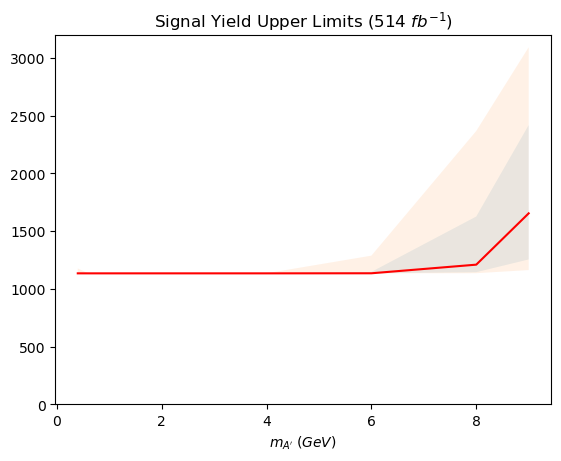

In [24]:
k = 5

fig, ax = plt.subplots(1, 1)

ax.plot(m, explim[k], c = 'r', label = 'Expected')
#ax.plot(m, obslim[k], 'o--', label = 'Observed')
ax.fill_between(m, explims1pos[k], explims1neg[k], alpha = 0.1, label = 'Expected (1$\sigma$)')
ax.fill_between(m, explims2pos[k], explims2neg[k], alpha = 0.1, label = 'Expected (2$\sigma$)')
ax.set_title('Signal Yield Upper Limits (514 $fb^{-1}$)')
ax.set_ylim(0,3200)
ax.set_xlabel(r"$m_{A'} \; (GeV)$")
fig.show()

In [20]:
def nsigtoepsilon(nsignal, mass, eff):
    
    lumi = 514
    
    cs = nsignal/(lumi*eff)
    
    alpha = 1/137
    
    Ecom = 10.58
    thetamax = 12*np.pi/180
    thetamin = 155*np.pi/180
    
    cssi = cs/(10**43)
    csgev = cssi/((0.197*1e-15)**2)
    
    b = 1 - mass**2/Ecom**2
    
    c = 1 + (2 * mass**2/Ecom**2)/b**2
    
    Theta = np.log(((1+np.cos(thetamax))*(1-np.cos(thetamin)))/((1-np.cos(thetamax))*(1+np.cos(thetamin))))
    
    a = csgev/(b * (c * Theta - np.cos(thetamax) + np.cos(thetamin)))
    
    epssquared = a/((2 * np.pi * alpha**2)/(Ecom**2))
    
    eps = np.sqrt(epssquared) 
      
    return eps

In [21]:
k = 5 

epsilonexplim = []
#epsilonobslim = []
epsilonexplims1pos = []
epsilonexplims1neg = []
epsilonexplims2pos = []
epsilonexplims2neg = []

for j in range(len(explim[k])):
    epsilonexplim.append(nsigtoepsilon(explim[k][j], m[j], efficiencies[j]))
    #epsilonobslim.append(nsigtoepsilon(obslim[k][j], m[j], efficiencies[j]))
    epsilonexplims1pos.append(nsigtoepsilon(explims1pos[k][j], m[j], efficiencies[j]))
    epsilonexplims1neg.append(nsigtoepsilon(explims1neg[k][j], m[j], efficiencies[j]))
    epsilonexplims2pos.append(nsigtoepsilon(explims2pos[k][j], m[j], efficiencies[j]))
    epsilonexplims2neg.append(nsigtoepsilon(explims2neg[k][j], m[j], efficiencies[j]))

/tmp/ipykernel_8364/3324967284.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


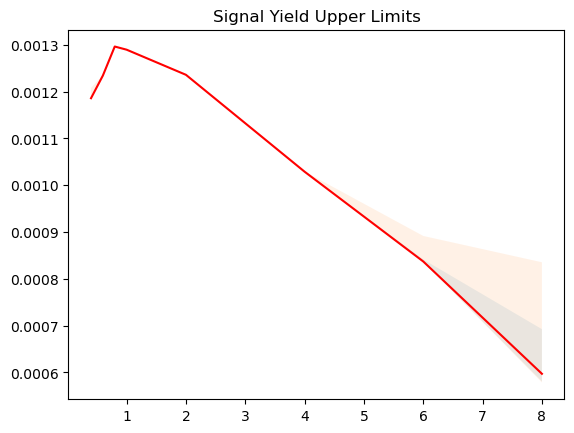

In [22]:
k = 5

fig, ax = plt.subplots(1, 1)

ax.plot(m[:-1], epsilonexplim[:-1], c = 'r', label = 'Expected')
#ax.plot(m[:-1], epsilonobslim[:-1], 'o--', label = 'Observed')
ax.fill_between(m[:-1], epsilonexplims1pos[:-1], epsilonexplims1neg[:-1], alpha = 0.1, label = 'Expected (1$\sigma$)')
ax.fill_between(m[:-1], epsilonexplims2pos[:-1], epsilonexplims2neg[:-1], alpha = 0.1, label = 'Expected (2$\sigma$)')
ax.set_title('$\epsilon$ Upper Limits')
ax.set_xlabel(r"$m_{A'} \; (GeV)$")
    
fig.show()

In [ ]:
epsilonexplim